## GROUP 8 

#### *Members:* 

1. Gianfranco Soria (20163509)
2. Erick Morales (20163041)
3. Andrea Clavo (20176040)
4. Sandra Martínez (20173026)

____
# *QUESTION 1*
____

____
# *QUESTION 2*
___

##### 1. Replicate the results of the script analyzing_rct_reemployment_experiment both in Python and R. Follow the next instructions:

- Focus on the Treatment group 2
- Plot two histograms for treatment and control group to see the distribution of the outcome variable inuidur1
- Run all specifications:
    * classical 2-sample approach, no adjustment (CL)
    * classical linear regression adjustment (CRA)
    * interactive regression adjustment (IRA)
    * interactive regression adjustment (IRA) using Lasso. I already fixed the problems in the Python code so please check again the Python script for the solution. For this now I used another package called hdmpy, you can see how to install it in this link. If you don´t want to use this package (which will give you the exact results as it is in R) just use the lasso from scikit-learn.

# Analyzing RCT data with Precision Adjustment

## Data

In this lab, we analyze the Pennsylvania re-employment bonus experiment, which was previously studied in "Sequential testing of duration data: the case of the Pennsylvania ‘reemployment bonus’ experiment" (Bilias, 2000), among others. These experiments were conducted in the 1980s by the U.S. Department of Labor to test the incentive effects of alternative compensation schemes for unemployment insurance (UI). In these experiments, UI claimants were randomly assigned either to a control group or one of five treatment groups. Actually, there are six treatment groups in the experiments. Here we focus on treatment group 4, but feel free to explore other treatment groups. In the control group the current rules of the UI applied. Individuals in the treatment groups were offered a cash bonus if they found a job within some pre-specified period of time (qualification period), provided that the job was retained for a specified duration. The treatments differed in the level of the bonus, the length of the qualification period, and whether the bonus was declining over time in the qualification period; see http://qed.econ.queensu.ca/jae/2000-v15.6/bilias/readme.b.txt for further details on data. 
  

- Focus on the Treatment group 2

In [1]:
## loading the data
Penn <- as.data.frame(read.table("../data/penn_jae.dat", header=T ))
n <- dim(Penn)[1]
p_1 <- dim(Penn)[2]
Penn<- subset(Penn, tg==2 | tg==0)
attach(Penn)

In [2]:
T2<- (tg==2)
summary(T2)

   Mode   FALSE    TRUE 
logical    3354    2428 

In [3]:
head(Penn)

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
1,10824,0,18,18,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,1,0
2,10635,2,7,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,10824,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,10754,2,20,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,10831,0,27,27,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,0,0


In [4]:
names(Penn)

[1] "abdt"       "tg"         "inuidur1"   "inuidur2"   "female"    
 [6] "black"      "hispanic"   "othrace"    "dep"        "q1"        
[11] "q2"         "q3"         "q4"         "q5"         "q6"        
[16] "recall"     "agelt35"    "agegt54"    "durable"    "nondurable"
[21] "lusd"       "husd"       "muld"

- Plot two histograms for treatment and control group to see the distribution of the outcome variable inuidur1

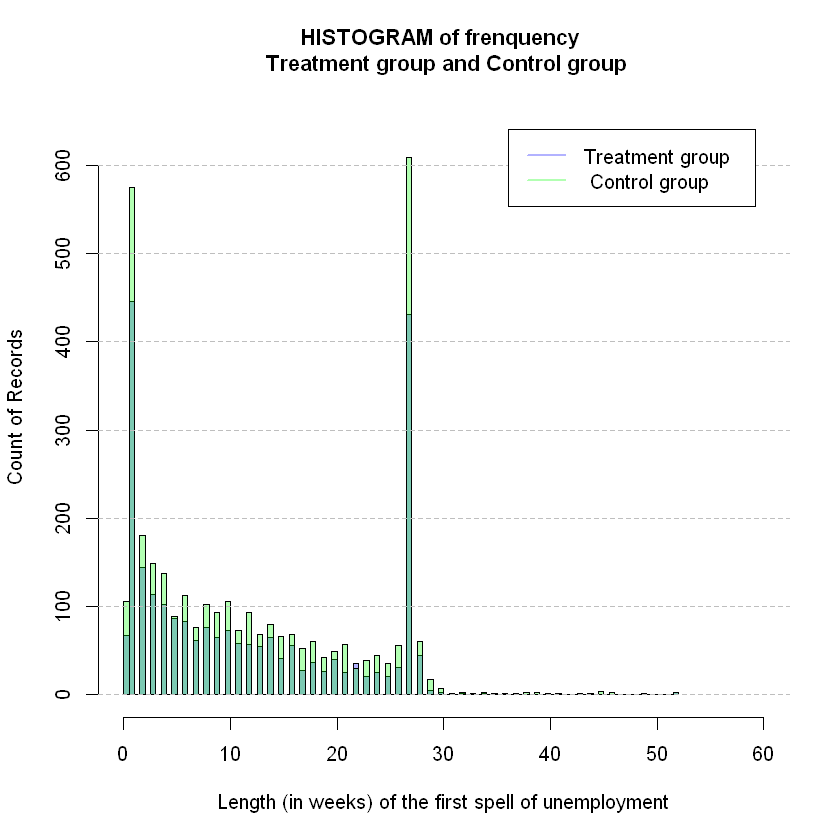

In [5]:
c1 <- rgb(0, 0, 1, 0.3) 
c2 <- rgb(0, 1, 0, 0.3)

hist(Penn$inuidur2[Penn$tg==2],ylim=c(0,650),xlim=c(0,60),xlab="Length (in weeks) of the first spell of unemployment"
     ,ylab="Count of Records",col=c1,cex.main = 1.1,breaks=80, 
     main = "HISTOGRAM of frenquency \n Treatment group and Control group")
hist(Penn$inuidur2[Penn$tg==0],breaks=80,add=T,col=c2)
grid(nx = NA, ny = NULL, lty = 2, col = "gray", lwd = 1)
legend("topright",
       inset = 0.05,
       legend = c("Treatment group", " Control group"),
       lty = c(1, 1),
       col = c(c1, c2),
       lwd = 2)

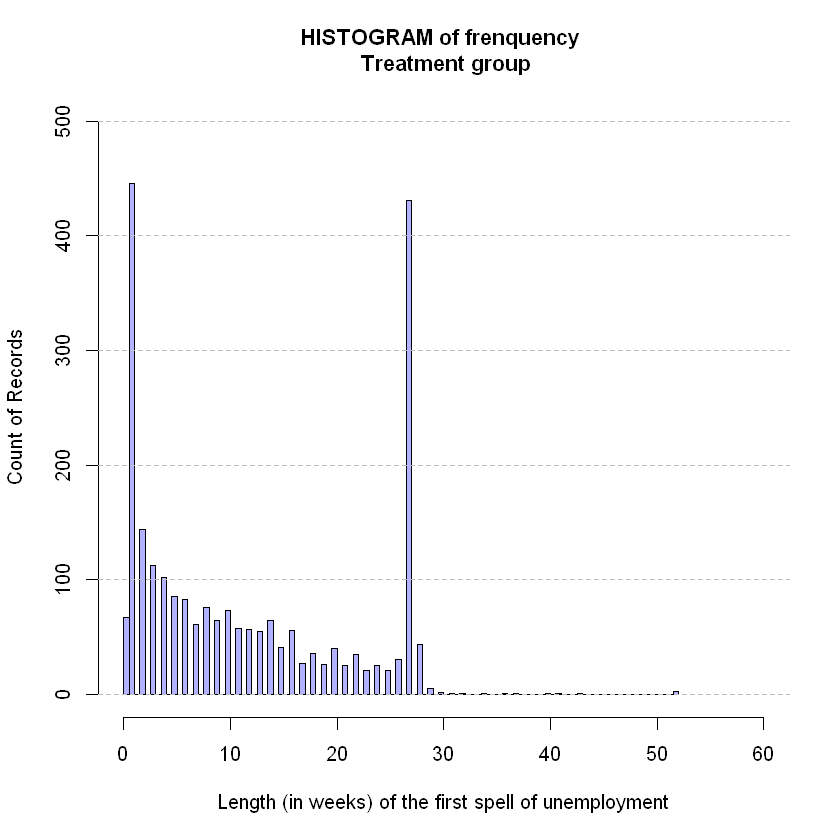

In [6]:
hist(Penn$inuidur2[Penn$tg==2],ylim=c(0,500),xlim=c(0,60),xlab="Length (in weeks) of the first spell of unemployment"
     ,ylab="Count of Records",col=c1,cex.main = 1.1,breaks=80, main = "HISTOGRAM of frenquency \n Treatment group")
grid(nx = NA, ny = NULL, lty = 2, col = "gray", lwd = 1)

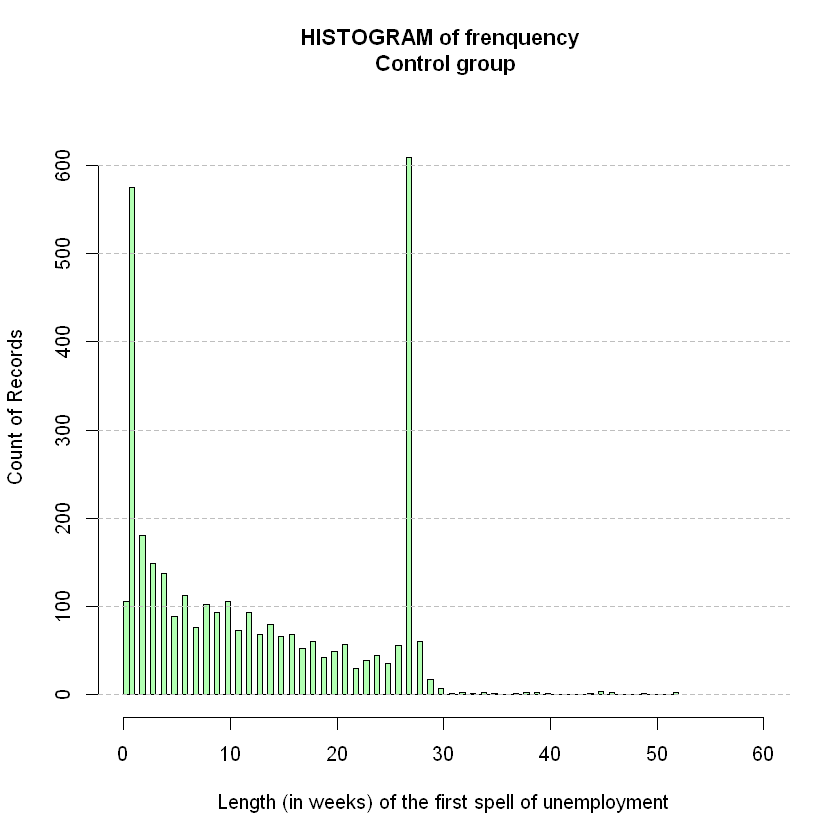

In [7]:
hist(Penn$inuidur2[Penn$tg==0],ylim=c(0,650),xlim=c(0,60),xlab="Length (in weeks) of the first spell of unemployment"
     ,ylab="Count of Records",col=c2,cex.main = 1.1,breaks=80, main = "HISTOGRAM of frenquency \n Control group")
grid(nx = NA, ny = NULL, lty = 2, col = "gray", lwd = 1)

### Model 
To evaluate the impact of the treatments on unemployment duration, we consider the linear regression model:

$$
Y =  D \beta_1 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W')' = 0,
$$

where $Y$ is  the  log of duration of unemployment, $D$ is a treatment  indicators,  and $W$ is a set of controls including age group dummies, gender, race, number of dependents, quarter of the experiment, location within the state, existence of recall expectations, and type of occupation.   Here $\beta_1$ is the ATE, if the RCT assumptions hold rigorously.


We also consider interactive regression model:

$$
Y =  D \alpha_1 + D W' \alpha_2 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W', DW')' = 0,
$$
where $W$'s are demeaned (apart from the intercept), so that $\alpha_1$ is the ATE, if the RCT assumptions hold rigorously.

Under RCT, the projection coefficient $\beta_1$ has
the interpretation of the causal effect of the treatment on
the average outcome. We thus refer to $\beta_1$ as the average
treatment effect (ATE). Note that the covariates, here are
independent of the treatment $D$, so we can identify $\beta_1$ by
just linear regression of $Y$ on $D$, without adding covariates.
However we do add covariates in an effort to improve the
precision of our estimates of the average treatment effect.

### Analysis

We consider 

*  classical 2-sample approach, no adjustment (CL)
*  classical linear regression adjustment (CRA)
*  interactive regression adjusment (IRA)

and carry out robust inference using the *estimatr* R packages. 

# Carry out covariate balance check

This is done using "lm_robust" command which unlike "lm" in the base command automatically does the correct Eicher-Huber-White standard errors, instead othe classical non-robus formula based on the homoscdedasticity command.

## Regress treatment on all covariates

In [10]:
#install.packages("lmtest")
m <- lm(T2~(female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
library(lmtest)
library(sandwich)
coeftest(m, vcov = vcovHC(m, type="HC1"))


t test of coefficients:

                       Estimate Std. Error t value  Pr(>|t|)    
(Intercept)           0.5171342  0.1568823  3.2963 0.0009856 ***
female                0.0056240  0.1324597  0.0425 0.9661352    
black                -0.0307771  0.0847262 -0.3633 0.7164293    
othrace              -0.4278818  0.3005502 -1.4237 0.1545993    
factor(dep)1          0.1576567  0.1851798  0.8514 0.3945992    
factor(dep)2         -0.1927958  0.1508926 -1.2777 0.2014067    
q2                   -0.1092161  0.1583768 -0.6896 0.4904762    
q3                   -0.1075663  0.1579864 -0.6809 0.4959890    
q4                   -0.0621302  0.1581168 -0.3929 0.6943797    
q5                   -0.0498684  0.1575034 -0.3166 0.7515450    
q6                   -0.2176336  0.1558290 -1.3966 0.1625831    
agelt35              -0.0643464  0.1326376 -0.4851 0.6276032    
agegt54               0.0259251  0.2395371  0.1082 0.9138171    
durable              -0.1256397  0.1763853 -0.7123 0.4763064    

We see that that even though this is a randomized experiment, balance conditions are failed.

# Model Specification

- classical 2-sample approach, no adjustment (CL)
- classical linear regression adjustment (CRA)

In [11]:
# model specifications


# no adjustment (2-sample approach)
formula_cl <- log(inuidur1)~T2

# adding controls
formula_cra <- log(inuidur1)~T2+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2
# Omitted dummies: q1, nondurable, muld


ols.cl <- lm(formula_cl)
ols.cra <- lm(formula_cra)


ols.cl = coeftest(ols.cl, vcov = vcovHC(ols.cl, type="HC1"))
ols.cra = coeftest(ols.cra, vcov = vcovHC(ols.cra, type="HC1"))

print(ols.cl)
print(ols.cra)




t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.056830   0.020954 98.1580  < 2e-16 ***
T2TRUE      -0.078825   0.032509 -2.4247  0.01535 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


t test of coefficients:

                       Estimate Std. Error t value  Pr(>|t|)    
(Intercept)           2.4471832  0.3580899  6.8340 9.123e-12 ***
T2TRUE               -0.0712066  0.0320440 -2.2222 0.0263124 *  
female               -0.9428048  0.2827961 -3.3339 0.0008620 ***
black                -0.6654258  0.2430567 -2.7377 0.0062056 ** 
othrace              -1.5494550  0.7312071 -2.1190 0.0341306 *  
factor(dep)1          0.2798498  0.3783316  0.7397 0.4595160    
factor(dep)2          0.1678164  0.3678718  0.4562 0.6482768    
q2                    0.0271228  0.3606226  0.0752 0.9400495    
q3                   -0.3542370  0.3601780 -0.9835 0.3254005    
q4                   -0.3380244  0.3606994 -0.9371 0.3487284    
q5 

In [12]:
summary(lm(formula_cra)) #to see which columns to remove when doing Python


Call:
lm(formula = formula_cra)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7486 -0.9882  0.3007  1.0086  2.2507 

Coefficients: (17 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.447183   0.381276   6.418 1.49e-10 ***
T2TRUE               -0.071207   0.032089  -2.219 0.026522 *  
female               -0.942805   0.313809  -3.004 0.002673 ** 
black                -0.665426   0.212970  -3.125 0.001790 ** 
othrace              -1.549455   0.990390  -1.564 0.117758    
factor(dep)1          0.279850   0.450985   0.621 0.534933    
factor(dep)2          0.167816   0.393591   0.426 0.669852    
q2                    0.027123   0.384918   0.070 0.943827    
q3                   -0.354237   0.383939  -0.923 0.356235    
q4                   -0.338024   0.384104  -0.880 0.378878    
q5                   -0.177717   0.382676  -0.464 0.642375    
q6                   -0.445604   0.381386  -1.168 0.242702  

The interactive specificaiton corresponds to the approach introduced in Lin (2013).

- Interactive regression adjustment (IRA)

### Without deleting correlated variables

In [13]:

#interactive regression model;

X = model.matrix (~ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)[,-1]
dim(X)
demean<- function(x){ x - mean(x)}
X = apply(X, 2, demean)

ols.ira = lm(log(inuidur1) ~ T2*X) 
ols.ira= coeftest(ols.ira, vcov = vcovHC(ols.ira, type="HC1"))
print(ols.ira)




[1] 5782  119


t test of coefficients:

                               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                   2.0556976  0.0207138 99.2430 < 2.2e-16 ***
T2TRUE                       -0.0699044  0.0320764 -2.1793 0.0293503 *  
Xfemale                      -0.6662823  0.4080234 -1.6330 0.1025357    
Xblack                       -0.8634862  0.2969435 -2.9079 0.0036528 ** 
Xothrace                     -3.8176881  0.9366193 -4.0760 4.645e-05 ***
Xfactor(dep)1                 0.0359264  0.6476816  0.0555 0.9557666    
Xfactor(dep)2                 0.2117556  0.4512231  0.4693 0.6388790    
Xq2                          -0.2546436  0.4553391 -0.5592 0.5760207    
Xq3                          -0.6212326  0.4549639 -1.3655 0.1721653    
Xq4                          -0.4799269  0.4561206 -1.0522 0.2927566    
Xq5                          -0.3718675  0.4538882 -0.8193 0.4126542    
Xq6                          -0.6770474  0.4521499 -1.4974 0.1343469    
Xagelt35                 

In [14]:
summary(lm(log(inuidur1) ~ T2*X) )


Call:
lm(formula = log(inuidur1) ~ T2 * X)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7359 -0.9551  0.2982  0.9769  2.4639 

Coefficients: (37 not defined because of singularities)
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   2.055698   0.020776  98.947  < 2e-16 ***
T2TRUE                       -0.069904   0.032316  -2.163  0.03057 *  
Xfemale                      -0.666282   0.444834  -1.498  0.13424    
Xblack                       -0.863486   0.269929  -3.199  0.00139 ** 
Xothrace                     -3.817688   1.722167  -2.217  0.02668 *  
Xfactor(dep)1                 0.035926   0.685311   0.052  0.95819    
Xfactor(dep)2                 0.211756   0.497004   0.426  0.67008    
Xq2                          -0.254644   0.527073  -0.483  0.62902    
Xq3                          -0.621233   0.525592  -1.182  0.23727    
Xq4                          -0.479927   0.526303  -0.912  0.36187    
Xq5                     

In [24]:
ols.ira$coeff

ERROR: Error in ols.ira$coeff: $ operator is invalid for atomic vectors


In [25]:
summary(ols.ira)

    Estimate          Std. Error         t value           Pr(>|t|)     
 Min.   :-4.45136   Min.   :0.02071   Min.   :-8.6102   Min.   :0.0000  
 1st Qu.:-0.21680   1st Qu.:0.23199   1st Qu.:-0.7365   1st Qu.:0.1421  
 Median : 0.06986   Median :0.43424   Median : 0.2459   Median :0.3920  
 Mean   : 0.07167   Mean   :0.47726   Mean   : 0.6142   Mean   :0.4131  
 3rd Qu.: 0.41143   3rd Qu.:0.65991   3rd Qu.: 0.9835   3rd Qu.:0.6424  
 Max.   : 4.78893   Max.   :1.89480   Max.   :99.2430   Max.   :0.9953  

Next we try out partialling out with lasso

In [21]:
#install.packages("hdm")

Warning message:
"package 'hdm' is in use and will not be installed"

In [22]:
library(hdm)

T2 = demean(T2)

DX = model.matrix(~T2*X)[,-1]

rlasso.ira = summary(rlassoEffects(DX, log(inuidur1), index = 1))


print(rlasso.ira)



[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)  
T2  -0.07457    0.03209  -2.324   0.0201 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




### Results

In [26]:
str(ols.ira)
ols.ira[2,1]

 'coeftest' num [1:203, 1:4] 2.0557 -0.0699 -0.6663 -0.8635 -3.8177 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:203] "(Intercept)" "T2TRUE" "Xfemale" "Xblack" ...
  ..$ : chr [1:4] "Estimate" "Std. Error" "t value" "Pr(>|t|)"
 - attr(*, "method")= chr "t test of coefficients"
 - attr(*, "df")= int 5579
 - attr(*, "nobs")= int 5782
 - attr(*, "logLik")=Class 'logLik' : -9129 (df=204)


[1] -0.0699044

In [27]:
library(xtable)
table<- matrix(0, 2, 4)
table[1,1]<-  ols.cl[2,1]
table[1,2]<-  ols.cra[2,1]
table[1,3]<-  ols.ira[2,1]
table[1,4]<-  rlasso.ira[[1]][1]

table[2,1]<-  ols.cl[2,2]
table[2,2]<-  ols.cra[2,2]
table[2,3]<-  ols.ira[2,2]
table[2,4]<-  rlasso.ira[[1]][2]


colnames(table)<- c("CL","CRA","IRA", "IRA w Lasso")
rownames(table)<- c("estimate", "standard error")
tab<- xtable(table, digits=5)
tab

print(tab, type="latex", digits=5)

,CL,CRA,IRA,IRA w Lasso
estimate,-0.07882533,-0.07120664,-0.06990440,-0.07457328
standard error,0.03250889,0.03204403,0.03207638,0.03208892


% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Fri Sep 24 11:14:54 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & CL & CRA & IRA & IRA w Lasso \\ 
  \hline
estimate & -0.07883 & -0.07121 & -0.06990 & -0.07457 \\ 
  standard error & 0.03251 & 0.03204 & 0.03208 & 0.03209 \\ 
   \hline
\end{tabular}
\end{table}


Treatment group 2 experiences an average decrease of about $7.8\%$ in the length of unemployment spell.


Observe that regression estimators delivers estimates that are slighly more efficient (lower standard errors) than the simple 2 mean estimator, but essentially all methods have very similar standard errors. From IRA results we also see that there is not any statistically detectable heterogeneity.  We also see the regression estimators offer slightly lower estimates -- these difference occur perhaps to due minor imbalance in the treatment allocation, which the regression estimators try to correct.


